In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table

import h5py
import nbodykit
from nbodykit.lab import *
#from nbodykit import style, setup_logging

from matplotlib import pyplot as plt

import sys
sys.path.append('../code')
import plotter
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
save = True
tag_mock = ''

### Set parameters

In [3]:
redshift = 0.7
cosmo = nbodykit.cosmology.Planck15
Plin = nbodykit.cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1_gal = 1.5
b1_agn = 2.5

Nmesh = 512
seed = 17

# ndens_gal = 1e-3
# ndens_agn = 1e-5
ndens_gal = 1e-4
ndens_agn = 1e-5

In [4]:
# how big a box do we need to go up to our desired zmax?
z_max = 1.4
dist_max = cosmo.comoving_distance(z_max)
print(dist_max)
boxsize = np.ceil(dist_max*2/500)*500 # times two because need on all sides; round to nearest 500
print(boxsize)

2903.092217020708
6000.0


In [5]:
# Number density consideration: For optimal results, you generally want the mesh resolution to be fine enough to resolve the mean inter-particle separation. If your galaxy number density is n, then the mean separation is approximately n^(-1/3). A good rule of thumb is to have your cell size (boxsize/nmesh) be smaller than this mean separation.
# Nyquist frequency: The nmesh parameter determines the maximum wavenumber (kmax) that can be resolved, which is π × nmesh/boxsize. This is important when considering the power spectrum analysis.

In [6]:
print(f'Mean interparticle separation galaxies: {1/np.cbrt(ndens_gal):.2f}')
print(f'Mean interparticle separation AGN: {1/np.cbrt(ndens_agn):.2f}')
print(f'Physical resolution: {boxsize/Nmesh:.2f} Mpc/h')
freq_nyquest = np.pi*Nmesh/boxsize
print(f'Nyquist frequency: {freq_nyquest:.2f} h/Mpc')

Mean interparticle separation galaxies: 21.54
Mean interparticle separation AGN: 46.42
Physical resolution: 11.72 Mpc/h
Nyquist frequency: 0.27 h/Mpc


### Generate tracer catalogs

In [7]:
# two catalogs with same seed should trace same underlying distribution
cat_gal = nbodykit.lab.LogNormalCatalog(Plin=Plin, nbar=ndens_gal, BoxSize=boxsize, Nmesh=Nmesh, bias=b1_gal, seed=seed)
cat_agn = nbodykit.lab.LogNormalCatalog(Plin=Plin, nbar=ndens_agn, BoxSize=boxsize, Nmesh=Nmesh, bias=b1_agn, seed=seed)

In [8]:
print(len(cat_gal['Position']))
print(len(cat_agn['Position']))

21598922
2160459


Text(0, 0.5, 'y [Mpc/h]')

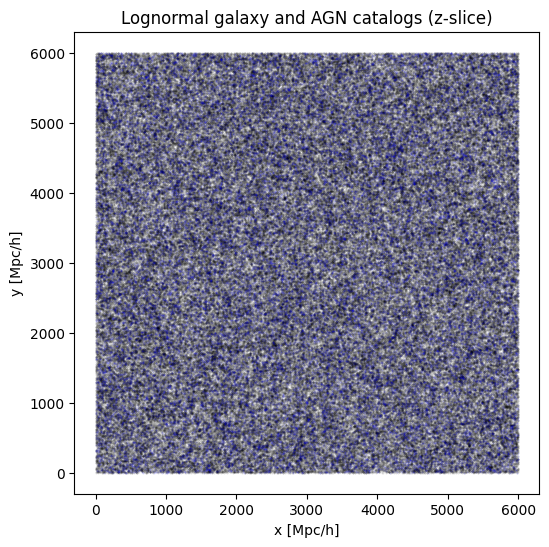

In [9]:
plt.figure(figsize=(6,6))
i_zslice_gal = cat_gal['Position'][:,2] < boxsize/50
plt.scatter(cat_gal['Position'][:,0][i_zslice_gal], cat_gal['Position'][:,1][i_zslice_gal], c='k', alpha=0.1, s=0.2)
i_zslice_agn = cat_agn['Position'][:,2] < boxsize/50
plt.scatter(cat_agn['Position'][:,0][i_zslice_agn], cat_agn['Position'][:,1][i_zslice_agn], c='b', alpha=0.1, s=0.4)
plt.title("Lognormal galaxy and AGN catalogs (z-slice)")
plt.xlabel('x [Mpc/h]')
plt.ylabel('y [Mpc/h]')

In [10]:
ra_gal, dec_gal, z_gal = nbodykit.transform.CartesianToSky(cat_gal['Position'], cosmo, velocity=cat_gal['Velocity'], 
                                               zmax=100, observer=[boxsize/2, boxsize/2, boxsize/2])
ra_agn, dec_agn, z_agn = nbodykit.transform.CartesianToSky(cat_agn['Position'], cosmo, velocity=cat_agn['Velocity'], 
                                               zmax=100, observer=[boxsize/2, boxsize/2, boxsize/2])

In [11]:
# cut at redshift smaller than boxsize/2 so we have a sphere
i_zmax_gal = z_gal < z_max
ra_gal, dec_gal, z_gal = ra_gal[i_zmax_gal], dec_gal[i_zmax_gal], z_gal[i_zmax_gal]
i_zmax_agn = z_agn < z_max
ra_agn, dec_agn, z_agn = ra_agn[i_zmax_agn], dec_agn[i_zmax_agn], z_agn[i_zmax_agn]


(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

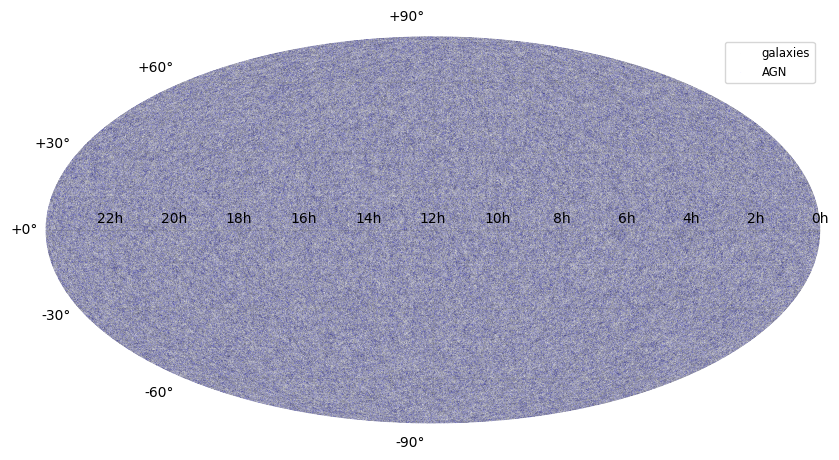

In [12]:
ra_arr = [ra_gal.compute(), ra_agn.compute()]
dec_arr = [dec_gal.compute(), dec_agn.compute()]
c_arr = ['k', 'b']
alpha_arr = [0.05, 0.1]
s_arr = [0.1, 0.2]
label_arr = ['galaxies', 'AGN']

plotter.create_skyplot(ra_arr, dec_arr, alpha_arr=alpha_arr, s_arr=s_arr, c_arr=c_arr, label_arr=label_arr)

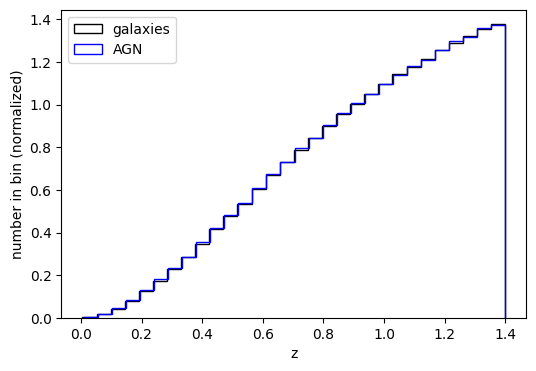

In [13]:
plt.figure(figsize=(6,4))
plt.hist(z_gal.compute(), bins=30, histtype='step', color='k', label='galaxies', density=True)
plt.hist(z_agn.compute(), bins=30, histtype='step', color='b', label='AGN', density=True)
plt.xlabel('z')
plt.ylabel('number in bin (normalized)')
plt.legend()

In [14]:
# Convert catalogs to mesh objects
mesh_gal = cat_gal.to_mesh(resampler='tsc', Nmesh=Nmesh, compensated=True, position='Position')
mesh_agn = cat_agn.to_mesh(resampler='tsc', Nmesh=Nmesh, compensated=True, position='Position')

In [15]:
r_cross = nbodykit.lab.FFTPower(first=mesh_gal, second=mesh_agn, mode='1d', dk=0.005)
r_gal = nbodykit.lab.FFTPower(first=mesh_gal, second=mesh_gal, mode='1d', dk=0.005)
r_agn = nbodykit.lab.FFTPower(first=mesh_agn, second=mesh_agn, mode='1d', dk=0.005)


In [16]:
# Get the power spectrum results
k = r_cross.power['k']
Pk_cross = r_cross.power['power'].real  # cross-spectrum is complex, take real part
Pk_gal = r_gal.power['power'].real  # auto-spectrum of galaxies
Pk_agn = r_agn.power['power'].real  # auto-spectrum of AGN

### Null check using diff random seed:

In [17]:
cat_agn_2 = nbodykit.lab.LogNormalCatalog(Plin=Plin, nbar=1e-7, BoxSize=boxsize, Nmesh=Nmesh, bias=b1_agn, seed=seed+1)

In [18]:
mesh_agn2 = cat_agn_2.to_mesh(resampler='tsc', Nmesh=512, compensated=True, position='Position')
r_cross2 = nbodykit.lab.FFTPower(first=mesh_gal, second=mesh_agn2, mode='1d', dk=0.005)
r_agn2 = nbodykit.lab.FFTPower(first=mesh_agn2, second=mesh_agn2, mode='1d', dk=0.005)

In [19]:
Pk_cross2 = r_cross2.power['power'].real  # cross-spectrum is complex, take real part
Pk_agn2 = r_agn2.power['power'].real  # auto-spectrum of AGN

### Plot results

In [20]:
print(2*np.pi/boxsize)
print(freq_nyquest)

0.0010471975511965976
0.268082573106329


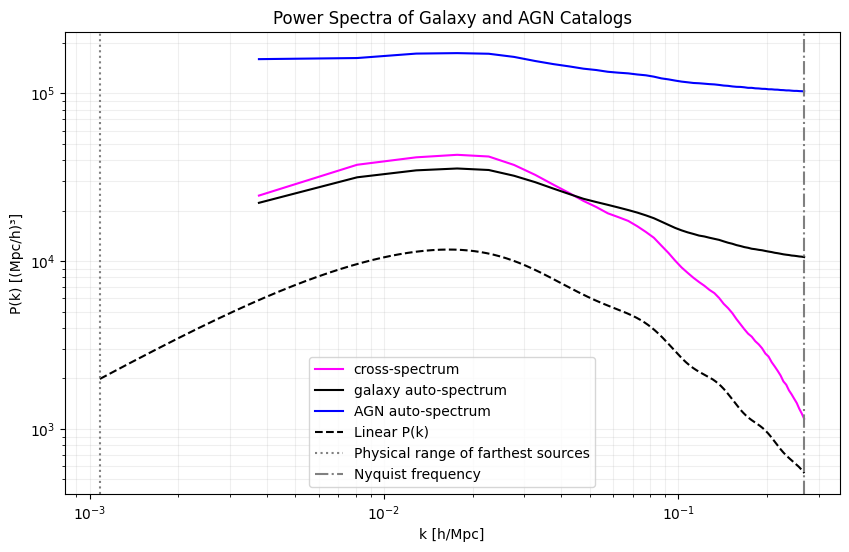

In [21]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the power spectra
plt.loglog(k, Pk_cross, color='magenta', ls='-', label='cross-spectrum')
#plt.loglog(k, Pk_cross2, color='gray', ls=':', label='null cross-spectrum')
plt.loglog(k, Pk_gal, color='k', label='galaxy auto-spectrum')
plt.loglog(k, Pk_agn, color='b', label='AGN auto-spectrum')
#plt.loglog(k, Pk_agn2, color='o', label='AGN auto-spectrum (2)')

k_min, k_max = 2*np.pi/(2*dist_max), freq_nyquest
k_lin = np.logspace(np.log10(k_min), np.log10(k_max), 1000)  # k range from 0.001 to 10 h/Mpc
plt.loglog(k_lin, Plin(k_lin), 'k--', label='Linear P(k)')
plt.axvline(k_min, color='grey', ls=':', label='Physical range of farthest sources')
plt.axvline(k_max, color='grey', ls='-.', label='Nyquist frequency')

# Enhance the main plot
plt.xlabel('k [h/Mpc]')
plt.ylabel('P(k) [(Mpc/h)³]')
plt.title('Power Spectra of Galaxy and AGN Catalogs')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

In [22]:
N_gal = len(ra_gal.compute())
N_agn = len(ra_agn.compute())

f_agn = 0.25
frac_gal, frac_agn = utils.compute_gw_host_fractions(N_gal, N_agn, f_agn)

A_norm: 1.1485e-07
Frac per object if f=0: 8.8745e-08
denominator: 8707257.75
Frac gal: 0.8824
Frac agn: 0.1176
Frac agn phys: 0.0294
Frac agn nonphys: 0.0882
Total fraction (should=1): 1.0000


In [23]:
rng = np.random.default_rng(seed=seed)

In [24]:
N_gw = 1000

N_gw_gal = round(frac_gal * N_gw)
N_gw_agn = round(frac_agn * N_gw)
print(f"Number of GW sources in galaxies: {N_gw_gal}")
print(f"Number of GW sources in AGN: {N_gw_agn}")
# Randomly select indices for GW sources in galaxies and AGN
i_gw_gal = rng.choice(np.arange(N_gal), N_gw_gal, replace=False)
i_gw_agn = rng.choice(np.arange(N_agn), N_gw_agn, replace=False)

Number of GW sources in galaxies: 882
Number of GW sources in AGN: 118


(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

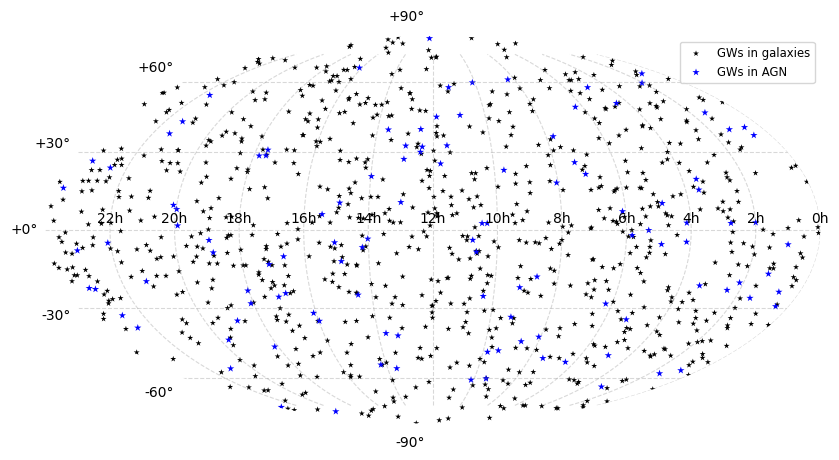

In [25]:
ra_gw_arr = [ra_gal.compute()[i_gw_gal], ra_agn.compute()[i_gw_agn]]
dec_gw_arr = [dec_gal.compute()[i_gw_gal], dec_agn.compute()[i_gw_agn]]
c_arr = ['k', 'b']
alpha_arr = [1, 1]
s_arr = [20, 30]
label_arr = ['GWs in galaxies', 'GWs in AGN']
marker_arr = ['*', '*']

plotter.create_skyplot(ra_gw_arr, dec_gw_arr, alpha_arr=alpha_arr, s_arr=s_arr, 
                       c_arr=c_arr, label_arr=label_arr, marker_arr=marker_arr)

## Save catalog, and test loading

In [29]:
def save_mock(fn_mock, ra_gal, dec_gal, z_gal,
              ra_agn, dec_agn, z_agn):# Save arrays to HDF5 file
    compression = 'gzip'
    compression_opts = 9
    with h5py.File(fn_mock, 'w') as f:
        # Create datasets with compression
        f.create_dataset('ra_gal', data=ra_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('dec_gal', data=dec_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('z_gal', data=z_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('ra_agn', data=ra_agn, compression=compression, compression_opts=compression_opts)
        f.create_dataset('dec_agn', data=dec_agn, compression=compression, compression_opts=compression_opts)
        f.create_dataset('z_agn', data=z_agn, compression=compression, compression_opts=compression_opts)
        f.create_dataset('i_gw_gal', data=i_gw_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('i_gw_agn', data=i_gw_agn, compression=compression, compression_opts=compression_opts)
        # attributes of sim
        f.attrs['n_gal'] = N_gal
        f.attrs['n_agn'] = N_agn
        f.attrs['f_agn'] = f_agn
        f.attrs['b1_gal'] = b1_gal
        f.attrs['b1_agn'] = b1_agn
        f.attrs['n_gw'] = N_gw
        f.attrs['ndens_gal'] = ndens_gal
        f.attrs['ndens_agn'] = ndens_agn
        f.attrs['redshift'] = redshift
        f.attrs['boxsize'] = boxsize
        f.attrs['Nmesh'] = Nmesh
        f.attrs['dist_max'] = dist_max
        f.attrs['z_max'] = z_max
        f.attrs['seed'] = seed
        # cosmology
        f.attrs['h'] = cosmo.h
        #f.attrs['Oc'] = cosmo.Oc0
        f.attrs['Ob'] = cosmo.Ob0
    print(f"Mock saved to {fn_mock}")

In [30]:
fn_mock = f'../data/mocks_nbodykit/mock_seed{seed}{tag_mock}.hdf5'
if save:
    save_mock(fn_mock, ra_gal, dec_gal, z_gal, ra_agn, dec_agn, z_agn)

Mock saved to ../data/mocks_nbodykit/mock_seed17.hdf5
